In [42]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns; sns.set()
import statsmodels.api as sm

from prophet import Prophet
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [5]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [39]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [35]:
vwap = netflix['volume_weighted_average_price']

In [36]:
netflix['simple_rtn'] = vwap.pct_change()
netflix['log_rtn'] = np.log(vwap/vwap.shift(1))

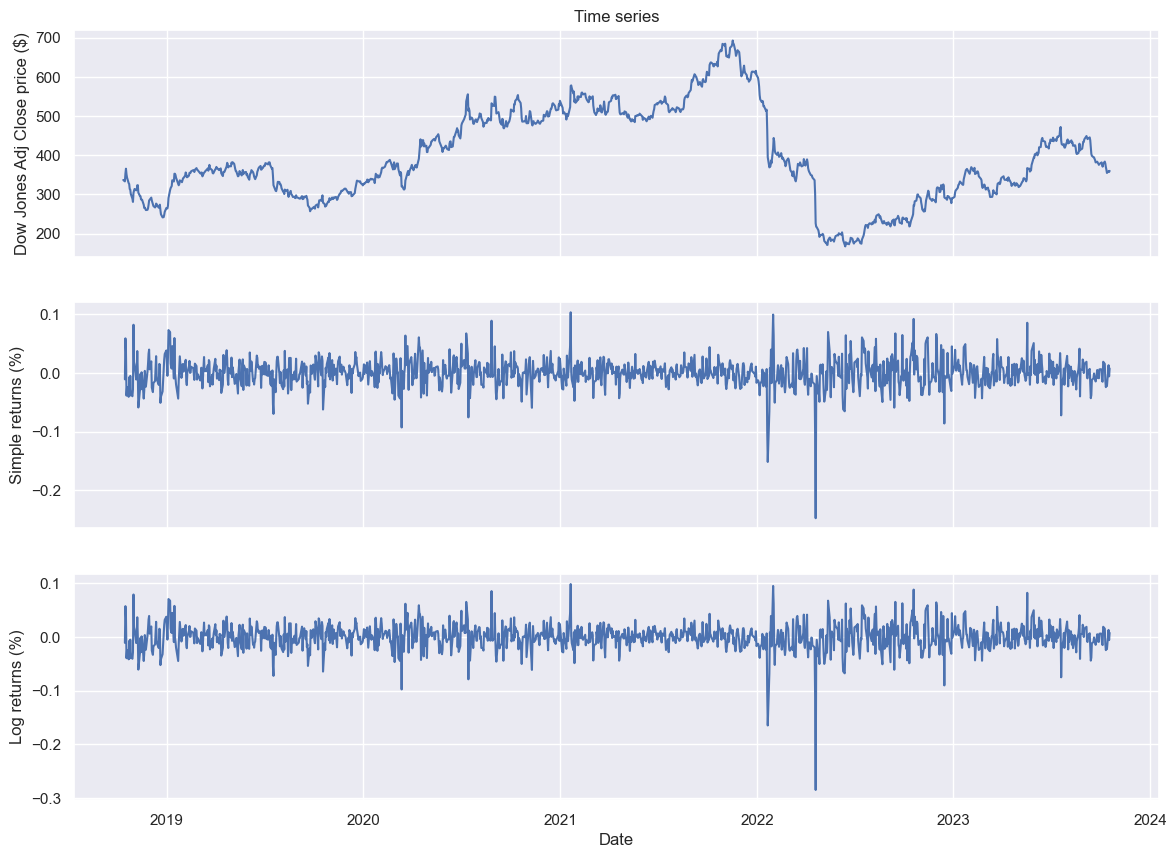

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Dow Jones Adj Close price ($)')
netflix.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
netflix.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show()

In [40]:
  hist = netflix[['volume_weighted_average_price']]
  hist.reset_index(level=0, inplace=True)
  hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds        yhat  yhat_lower  yhat_upper
1622 2024-10-13  651.682067  366.953531  956.927503
1623 2024-10-14  646.128195  354.974436  947.356313
1624 2024-10-15  649.681266  356.715389  952.233316
1625 2024-10-16  651.945788  363.232216  950.403102
1626 2024-10-17  654.291239  357.273902  960.233190


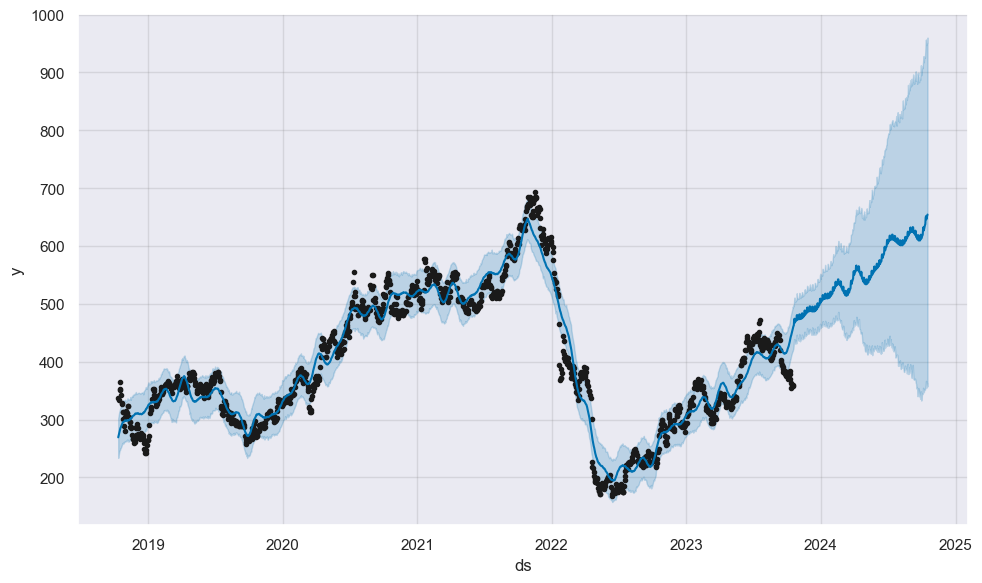

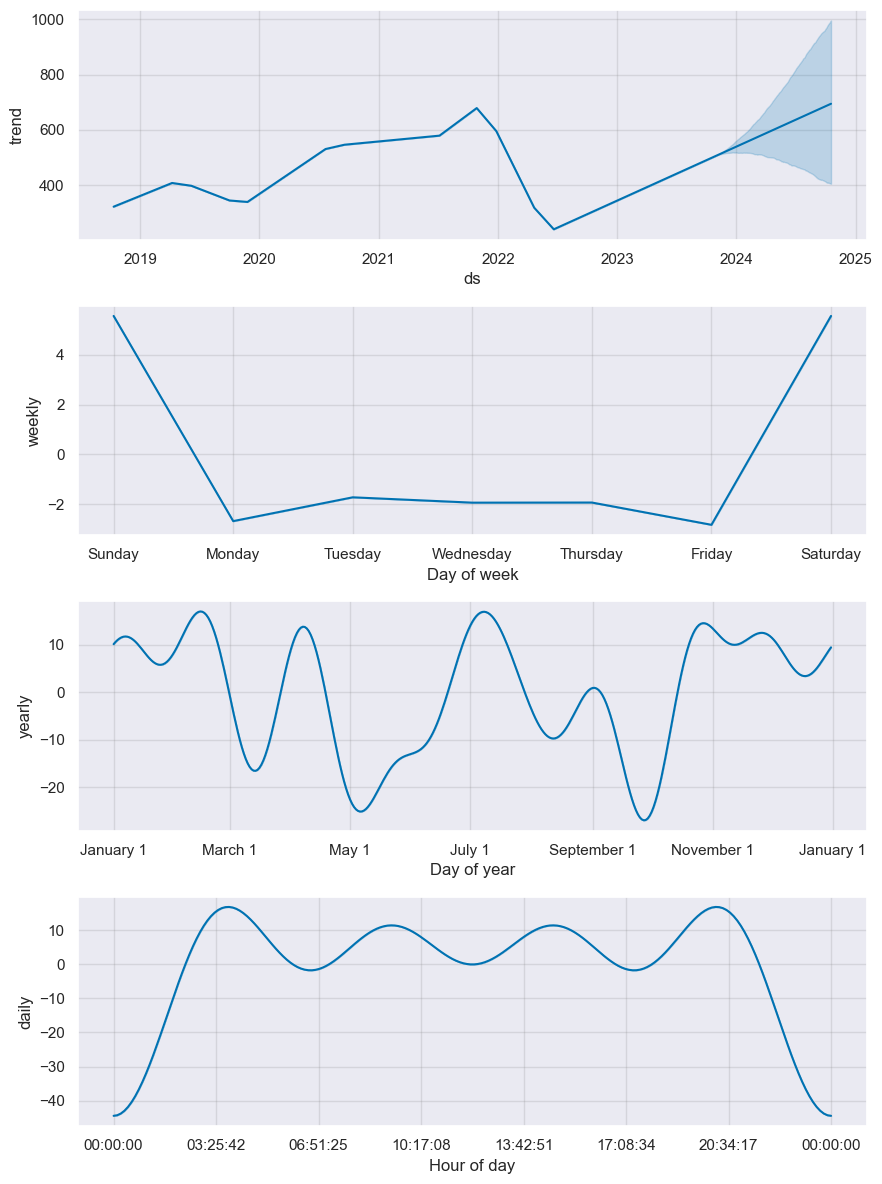

In [44]:
  m = Prophet(daily_seasonality=True)
  m.fit(hist)
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)
  print("Predicted Data")
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
  figure1 = m.plot(forecast)
  figure2 = m.plot_components(forecast)